Name: Sau Chow 100% - Student ID: 000734527
Name: Weifeng Ma 0%

Project Name: Movie Success Prediction Project
Class: CMPE255

This section includes exploratory data analysis and prediction models + results

In [1]:
!pip install dython
!pip install cpi

import pandas as pd
import numpy as np
import cpi
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from dython import nominal

from google.colab import files
uploaded = files.upload()

#Imports and Load Dataset 
#Load dataset after merging fields OMdb_merged.csv

Saving OMdb_merged.csv to OMdb_merged (1).csv


In [2]:
pd.set_option('max_columns', None)

In [3]:
OMdb = pd.read_csv('OMdb_merged.csv')

In [4]:
OMdb.head(2)

,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,IMdb_ID,IMdb_score,Language,Metascore,Plot,Production,RT_score,Rated,Released,Runtime,TMdb_id,Title,Type,Website,Year,actor_1,actor_2,awards,bo_year,bo_year_rank,director_1,director_2,domestic-gross,domestic-pct,imdbVotes,itunes_id,logBoxOffice,mojo_title,nominations,num_actor,num_director,num_genre,num_lang,oscar_noms,oscar_wins,overseas-gross,overseas-pct,search_strs,studio,titles,worldwide-gross,years,Writer 1,Writer 2,Writer 3,Writer 4,budget,Cast 1,Cast 2,Cast 3,Cast 4,Cast 5,Cast 6
0,"Neel Sethi, Bill Murray, Ben Kingsley, Idris Elba",Won 1 Oscar. Another 31 wins & 54 nominations.,363995937.0,"UK, USA",30 Aug 2016,Jon Favreau,"Adventure, Drama, Family, Fantasy",tt3040964,74.0,English,77.0,After a threat from the tiger Shere Khan force...,Walt Disney Pictures,95.0,PG,15 Apr 2016,106.0,"[278927, 183407, 534412, 399014]",The Jungle Book,movie,http://movies.disney.com/the-jungle-book-2016,2016,Neel Sethi,Bill Murray,31.0,2016.0,5.0,Jon Favreau,0,364000000.0,37.7,231929.0,1098066757,8.561097,The Jungle Book 2016,54.0,4,1,4,1.0,0.0,1.0,602500000.0,62.3,The+Jungle+Book+2016,BV,The Jungle Book (2016),966600000.0,2016,Justin Marks,Writer Not Available,Writer Not Available,Writer Not Available,175000000.0,Neel Sethi,Neel Sethi,Bill Murray,Ben Kingsley,Idris Elba,Lupita Nyong'o
1,"Neel Sethi, Bill Murray, Ben Kingsley, Idris Elba",Won 1 Oscar. Another 31 wins & 54 nominations.,363995937.0,"UK, USA",30 Aug 2016,Jon Favreau,"Adventure, Drama, Family, Fantasy",tt3040964,74.0,English,77.0,After a threat from the tiger Shere Khan force...,Walt Disney Pictures,95.0,PG,15 Apr 2016,106.0,"[278927, 183407, 534412, 399014]",The Jungle Book,movie,http://movies.disney.com/the-jungle-book-2016,2016,Neel Sethi,Bill Murray,31.0,2016.0,5.0,Jon Favreau,0,364000000.0,37.7,231929.0,1098066757,8.561097,The Jungle Book 2016,54.0,4,1,4,1.0,0.0,1.0,602500000.0,62.3,The+Jungle+Book+2016,BV,The Jungle Book (2016),966600000.0,2016,Justin Marks,Writer Not Available,Writer Not Available,Writer Not Available,175000000.0,Bruce Reitherman,Louis Prima,Sterling Holloway,J. Pat O'Malley,Darleen Carr,Phil Harris


### Data Preprocessing

In [5]:
'''Adjust the worldwide-gross and budget column values for inflation
https://medium.com/analytics-vidhya/adjusting-for-inflation-when-analysing-historical-dat a-with-python-9d69a8dcbc27
'''

cpi.update()
def inflate_column(data, column): 
    return data.apply(lambda x:cpi.inflate(x[column], x.Year), axis = 1)

In [6]:
OMdb['real_budget'] = inflate_column(OMdb, 'budget')
OMdb['real_revenue'] = inflate_column(OMdb, 'worldwide-gross')

ref: https://medium.com/analytics-vidhya/adjusting-for-inflation-when-analysing-historical-data-with-python-9d69a8dcbc27

Drop redundant columns:
1. Actors and Director
2. titles, mojo_title, and search_strs
3.  IMdb_ID, TMdb_id and itunes_id 

In [7]:
OMdb.columns

Index(['Actors', 'Awards', 'BoxOffice', 'Country', 'DVD', 'Director', 'Genre',
       'IMdb_ID', 'IMdb_score', 'Language', 'Metascore', 'Plot', 'Production',
       'RT_score', 'Rated', 'Released', 'Runtime', 'TMdb_id', 'Title', 'Type',
       'Website', 'Year', 'actor_1', 'actor_2', 'awards', 'bo_year',
       'bo_year_rank', 'director_1', 'director_2', 'domestic-gross',
       'domestic-pct', 'imdbVotes', 'itunes_id', 'logBoxOffice', 'mojo_title',
       'nominations', 'num_actor', 'num_director', 'num_genre', 'num_lang',
       'oscar_noms', 'oscar_wins', 'overseas-gross', 'overseas-pct',
       'search_strs', 'studio', 'titles', 'worldwide-gross', 'years',
       'Writer 1', 'Writer 2', 'Writer 3', 'Writer 4', 'budget', 'Cast 1',
       'Cast 2', 'Cast 3', 'Cast 4', 'Cast 5', 'Cast 6', 'real_budget',
       'real_revenue'],
      dtype='object')

In [8]:
# Title and titles are the same, but titles also include year. We already have a column Year so I'm deleting titles. 
OMdb.loc[OMdb['Title']!= OMdb['titles'], ['Title', 'titles']]

# Same thing, deleting mojo_title
OMdb.loc[OMdb['Title']!= OMdb['mojo_title'], ['Title', 'mojo_title']]

# same thing as search_strs. 
OMdb['search_strs']

0                         The+Jungle+Book+2016
1                         The+Jungle+Book+2016
2                         The+Jungle+Book+2016
3                         The+Jungle+Book+2016
4                       A+Christmas+Carol+2009
                        ...                   
403                                 Kick-Ass+2
404            Alice+Through+the+Looking+Glass
405    The+Chronicles+of+Narnia+Prince+Caspian
406                         The+Golden+Compass
407                        The+Matrix+Reloaded
Name: search_strs, Length: 408, dtype: object

In [9]:
new_OMdb = OMdb.drop(columns = ['Actors', 'Director', 'titles', 'mojo_title', 'search_strs', 'IMdb_ID','itunes_id', 'TMdb_id'])

In [10]:
new_OMdb.columns

Index(['Awards', 'BoxOffice', 'Country', 'DVD', 'Genre', 'IMdb_score',
       'Language', 'Metascore', 'Plot', 'Production', 'RT_score', 'Rated',
       'Released', 'Runtime', 'Title', 'Type', 'Website', 'Year', 'actor_1',
       'actor_2', 'awards', 'bo_year', 'bo_year_rank', 'director_1',
       'director_2', 'domestic-gross', 'domestic-pct', 'imdbVotes',
       'logBoxOffice', 'nominations', 'num_actor', 'num_director', 'num_genre',
       'num_lang', 'oscar_noms', 'oscar_wins', 'overseas-gross',
       'overseas-pct', 'studio', 'worldwide-gross', 'years', 'Writer 1',
       'Writer 2', 'Writer 3', 'Writer 4', 'budget', 'Cast 1', 'Cast 2',
       'Cast 3', 'Cast 4', 'Cast 5', 'Cast 6', 'real_budget', 'real_revenue'],
      dtype='object')

In [11]:
# change column names for groupby to work in the feature selection. 
OMdb = new_OMdb.rename(columns = {
    'bo_year':'bo-year',
    'bo_year_rank': 'bo-year-rank',
    'num_actor': 'num-actor',
    'num_director': 'num-director',
    'num_genre': 'num-genre',
    'oscar_noms': 'oscar-noms',
    'oscar_wins': 'oscar-wins',
    'IMdb_score': 'IMdb-score',
    'num_lang': 'num-lang',
    'RT_score': 'RT-score',
    'real_budget': 'real-budget'
})

Exploratory Data Analysis

In [12]:
corr_df = OMdb[['Awards', 'Runtime','IMdb-score', 'worldwide-gross', 'director_2', 'Production', 'studio',
               'imdbVotes','Rated', 'oscar-noms', 'nominations','Writer 4', 'oscar-wins', 'Writer 1',
               'Writer 3', 'Writer 2', 'Language']]

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


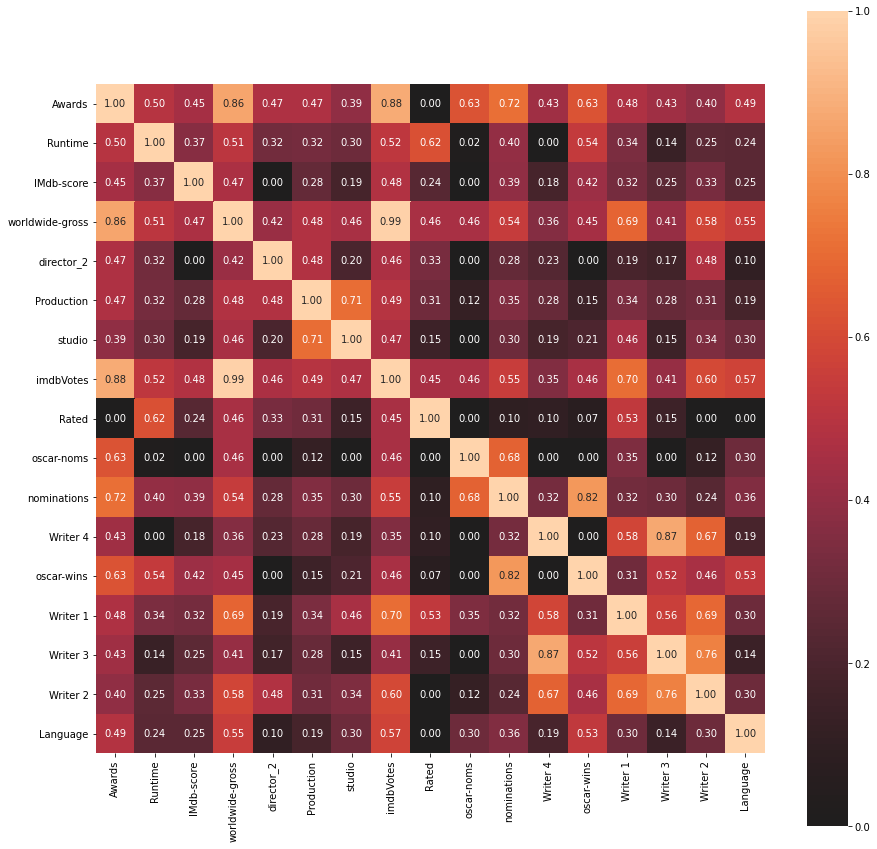

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5fbc8bb6d8>,
 'corr':                    Awards   Runtime  IMdb-score  worldwide-gross  director_2  \
 Awards           1.000000  0.498322    0.447248         0.861721    0.472546   
 Runtime          0.498322  1.000000    0.374622         0.511502    0.318858   
 IMdb-score       0.447248  0.374622    1.000000         0.467587    0.000000   
 worldwide-gross  0.861721  0.511502    0.467587         1.000000    0.418568   
 director_2       0.472546  0.318858    0.000000         0.418568    1.000000   
 Production       0.468967  0.321055    0.278752         0.479393    0.479399   
 studio           0.392234  0.303633    0.185415         0.457883    0.202660   
 imdbVotes        0.876652  0.521157    0.478174         0.990788    0.464311   
 Rated            0.000000  0.623401    0.237136         0.456937    0.334153   
 oscar-noms       0.628490  0.023250    0.000000         0.457818    0.000000   
 nominations      0.716231  0.40163

In [13]:
nominal.associations(corr_df, nominal_columns = 'all', figsize=(15, 15), annot =True)

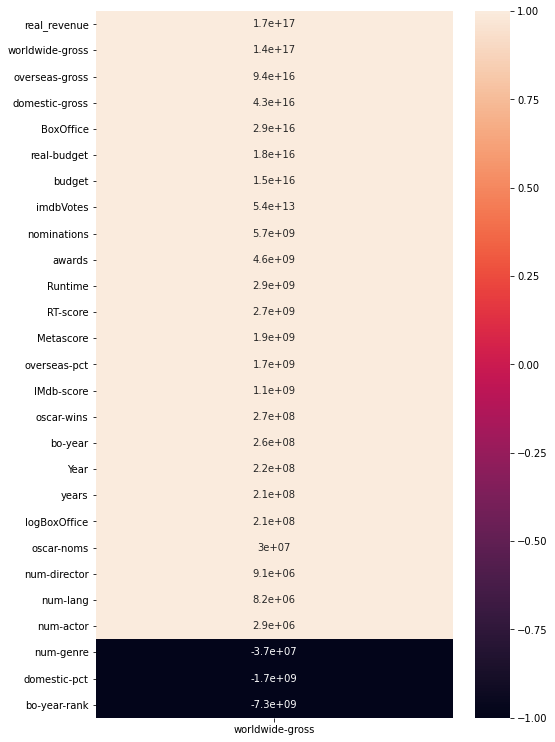

In [14]:
#for only numeric data
plt.figure(figsize=(8, 13))
cov_omdb = OMdb.cov().loc[:,['worldwide-gross']].sort_values(by='worldwide-gross', ascending = False)
sns.heatmap(cov_omdb, annot = True, vmin = -1, vmax =1)
plt.savefig('OMdbcov for numeric data.png')

Since movie runtime is in units of minutes (100 minutes) and revenue/budget is in millions of dollars ($100M), the dataset columns will need to be normalized.

In [15]:
scaler = MinMaxScaler()
OMdb_scaled = scaler.fit_transform(OMdb._get_numeric_data())

In [16]:
norm = pd.DataFrame(OMdb_scaled, columns = OMdb._get_numeric_data().columns)

In [17]:
norm.head(2)

,BoxOffice,IMdb-score,Metascore,RT-score,Runtime,Year,awards,bo-year,bo-year-rank,domestic-gross,domestic-pct,imdbVotes,logBoxOffice,nominations,num-actor,num-director,num-genre,num-lang,oscar-noms,oscar-wins,overseas-gross,overseas-pct,worldwide-gross,years,budget,real-budget,real_revenue
0,0.485522,0.757576,0.736256,0.935347,0.469274,0.964286,0.133621,1.0,0.02381,0.485452,0.366226,0.116529,0.964643,0.246575,1.0,0.0,0.5,0.0,0.0,0.090909,0.297164,0.633774,0.348045,0.964286,0.58166,0.500992,0.303625
1,0.485522,0.757576,0.736256,0.935347,0.469274,0.964286,0.133621,1.0,0.02381,0.485452,0.366226,0.116529,0.964643,0.246575,1.0,0.0,0.5,0.0,0.0,0.090909,0.297164,0.633774,0.348045,0.964286,0.58166,0.500992,0.303625


In [18]:
def replace_norms(OMdb_df, norm_df):
    cols = norm_df.columns
    for col in cols: 
        OMdb_df[col] = norm_df[col]

In [19]:
replace_norms(OMdb, norm)

In [20]:
OMdb.head(2)

,Awards,BoxOffice,Country,DVD,Genre,IMdb-score,Language,Metascore,Plot,Production,RT-score,Rated,Released,Runtime,Title,Type,Website,Year,actor_1,actor_2,awards,bo-year,bo-year-rank,director_1,director_2,domestic-gross,domestic-pct,imdbVotes,logBoxOffice,nominations,num-actor,num-director,num-genre,num-lang,oscar-noms,oscar-wins,overseas-gross,overseas-pct,studio,worldwide-gross,years,Writer 1,Writer 2,Writer 3,Writer 4,budget,Cast 1,Cast 2,Cast 3,Cast 4,Cast 5,Cast 6,real-budget,real_revenue
0,Won 1 Oscar. Another 31 wins & 54 nominations.,0.485522,"UK, USA",30 Aug 2016,"Adventure, Drama, Family, Fantasy",0.757576,English,0.736256,After a threat from the tiger Shere Khan force...,Walt Disney Pictures,0.935347,PG,15 Apr 2016,0.469274,The Jungle Book,movie,http://movies.disney.com/the-jungle-book-2016,0.964286,Neel Sethi,Bill Murray,0.133621,1.0,0.02381,Jon Favreau,0,0.485452,0.366226,0.116529,0.964643,0.246575,1.0,0.0,0.5,0.0,0.0,0.090909,0.297164,0.633774,BV,0.348045,0.964286,Justin Marks,Writer Not Available,Writer Not Available,Writer Not Available,0.58166,Neel Sethi,Neel Sethi,Bill Murray,Ben Kingsley,Idris Elba,Lupita Nyong'o,0.500992,0.303625
1,Won 1 Oscar. Another 31 wins & 54 nominations.,0.485522,"UK, USA",30 Aug 2016,"Adventure, Drama, Family, Fantasy",0.757576,English,0.736256,After a threat from the tiger Shere Khan force...,Walt Disney Pictures,0.935347,PG,15 Apr 2016,0.469274,The Jungle Book,movie,http://movies.disney.com/the-jungle-book-2016,0.964286,Neel Sethi,Bill Murray,0.133621,1.0,0.02381,Jon Favreau,0,0.485452,0.366226,0.116529,0.964643,0.246575,1.0,0.0,0.5,0.0,0.0,0.090909,0.297164,0.633774,BV,0.348045,0.964286,Justin Marks,Writer Not Available,Writer Not Available,Writer Not Available,0.58166,Bruce Reitherman,Louis Prima,Sterling Holloway,J. Pat O'Malley,Darleen Carr,Phil Harris,0.500992,0.303625


Run onehotencoding on the normalized and adjusted dataset

In [21]:
cat_cols = np.array(pd.DataFrame(OMdb.dtypes[OMdb.dtypes == 'object']).index)

In [22]:
ohe = OneHotEncoder(drop = 'first')
ohe_array = ohe.fit_transform(OMdb[cat_cols]).toarray()
ohe_OMdb = pd.DataFrame(ohe_array, index = OMdb.index, columns = ohe.get_feature_names(cat_cols ))

In [23]:
ohe_OMdb.to_csv('ohe_cols.csv', index = False)

from google.colab import files
files.download("ohe_cols.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
OMdb_drop_col = OMdb.drop(columns = cat_cols)

In [25]:
OMdb_ohed = pd.concat([OMdb_drop_col, ohe_OMdb], axis = 1)

In [26]:
OMdb_ohed.columns

Index(['BoxOffice', 'IMdb-score', 'Metascore', 'RT-score', 'Runtime', 'Year',
       'awards', 'bo-year', 'bo-year-rank', 'domestic-gross',
       ...
       'Cast 6_Ving Rhames', 'Cast 6_Wagner Moura', 'Cast 6_Walter Brennan',
       'Cast 6_Wang Xueqin', 'Cast 6_Warwick Davis', 'Cast 6_William H. Macy',
       'Cast 6_William Kircher', 'Cast 6_William Lee Scott',
       'Cast 6_William Sadler', 'Cast 6_Ziyi Zhang'],
      dtype='object', length=5128)

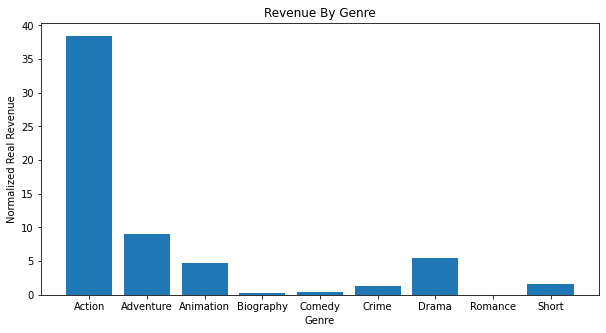

In [27]:
'''
Plot revenue by genre. Revenue comes from “worldwide-gross” and “Genre” in OMDb_mojo_clean.csv. 
'''

OMdb['genre_1'] = [i.split(',')[0] for i in OMdb['Genre'] ]
genre_revenue_df= pd.DataFrame(OMdb.groupby(['genre_1']).sum()['real_revenue'])
plt.figure(figsize = (10, 5))
plt.bar(genre_revenue_df.index, genre_revenue_df['real_revenue'])
plt.title('Revenue By Genre')
plt.xlabel('Genre')
plt.ylabel('Normalized Real Revenue')
plt.savefig('real_revenue_by_genre.png');

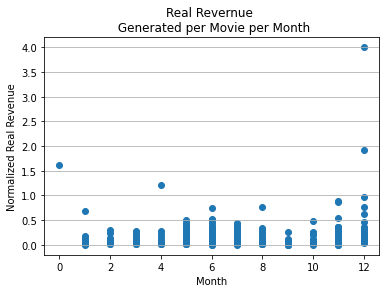

In [28]:
'''
Take all the movies and bin them by the month that they are released. 
Then plot them against the revenue generated per movie.
'''
month = []
for data in OMdb['Released']:
    if data != '0':
        month.append(pd.to_datetime(data).month)
    else:
        month.append(0)
        
OMdb['month'] = month
month_revenue_df =pd.DataFrame(OMdb.groupby(by = ['month', 'Title']).sum()['real_revenue'])
month_revenue_df.reset_index(inplace = True)
plt.scatter(month_revenue_df['month'], month_revenue_df['real_revenue'])
plt.title('Real Revernue \n Generated per Movie per Month')
plt.xlabel('Month')
plt.grid(True, which='major', axis='y')
plt.ylabel('Normalized Real Revenue')
plt.savefig('real_revenue_per_movie_per_month.png');

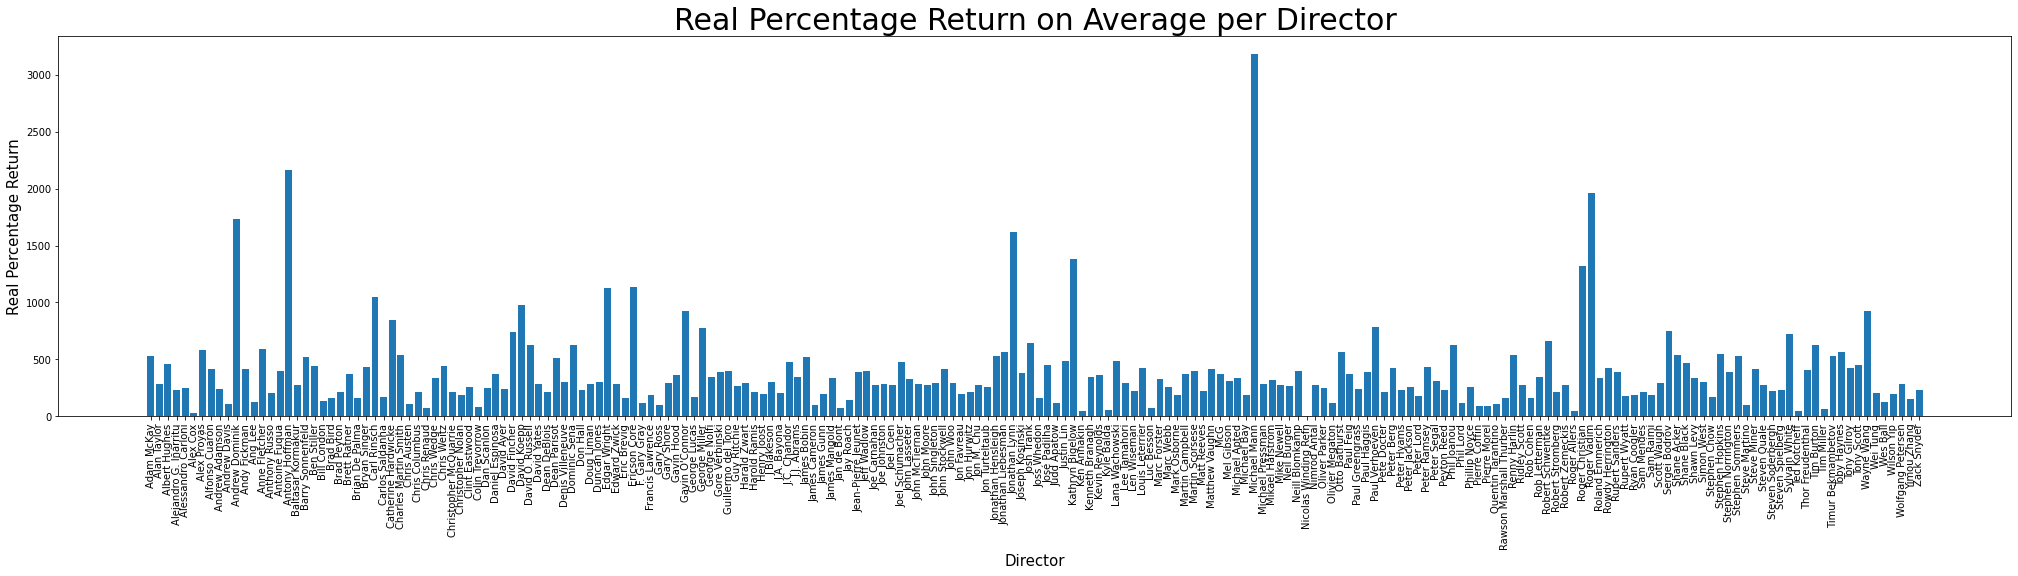

In [29]:
'''
(budget/revenue) * 100% equals percentage return on a movie
bin the movies by the director
'''
OMdb['pct_return'] = OMdb['real-budget']/OMdb['real_revenue']*100
revenue_director_df = pd.DataFrame(OMdb.groupby(by=['director_1']).mean()['pct_return'])
plt.figure(figsize = (35,7))
plt.bar(revenue_director_df.index, revenue_director_df['pct_return'])
plt.title('Real Percentage Return on Average per Director', fontsize = 30)
plt.xlabel('Director', fontsize = 15)
plt.ylabel('Real Percentage Return', fontsize = 15)
plt.xticks(rotation = 90)
plt.savefig('real_percentage_return_per_director.png');

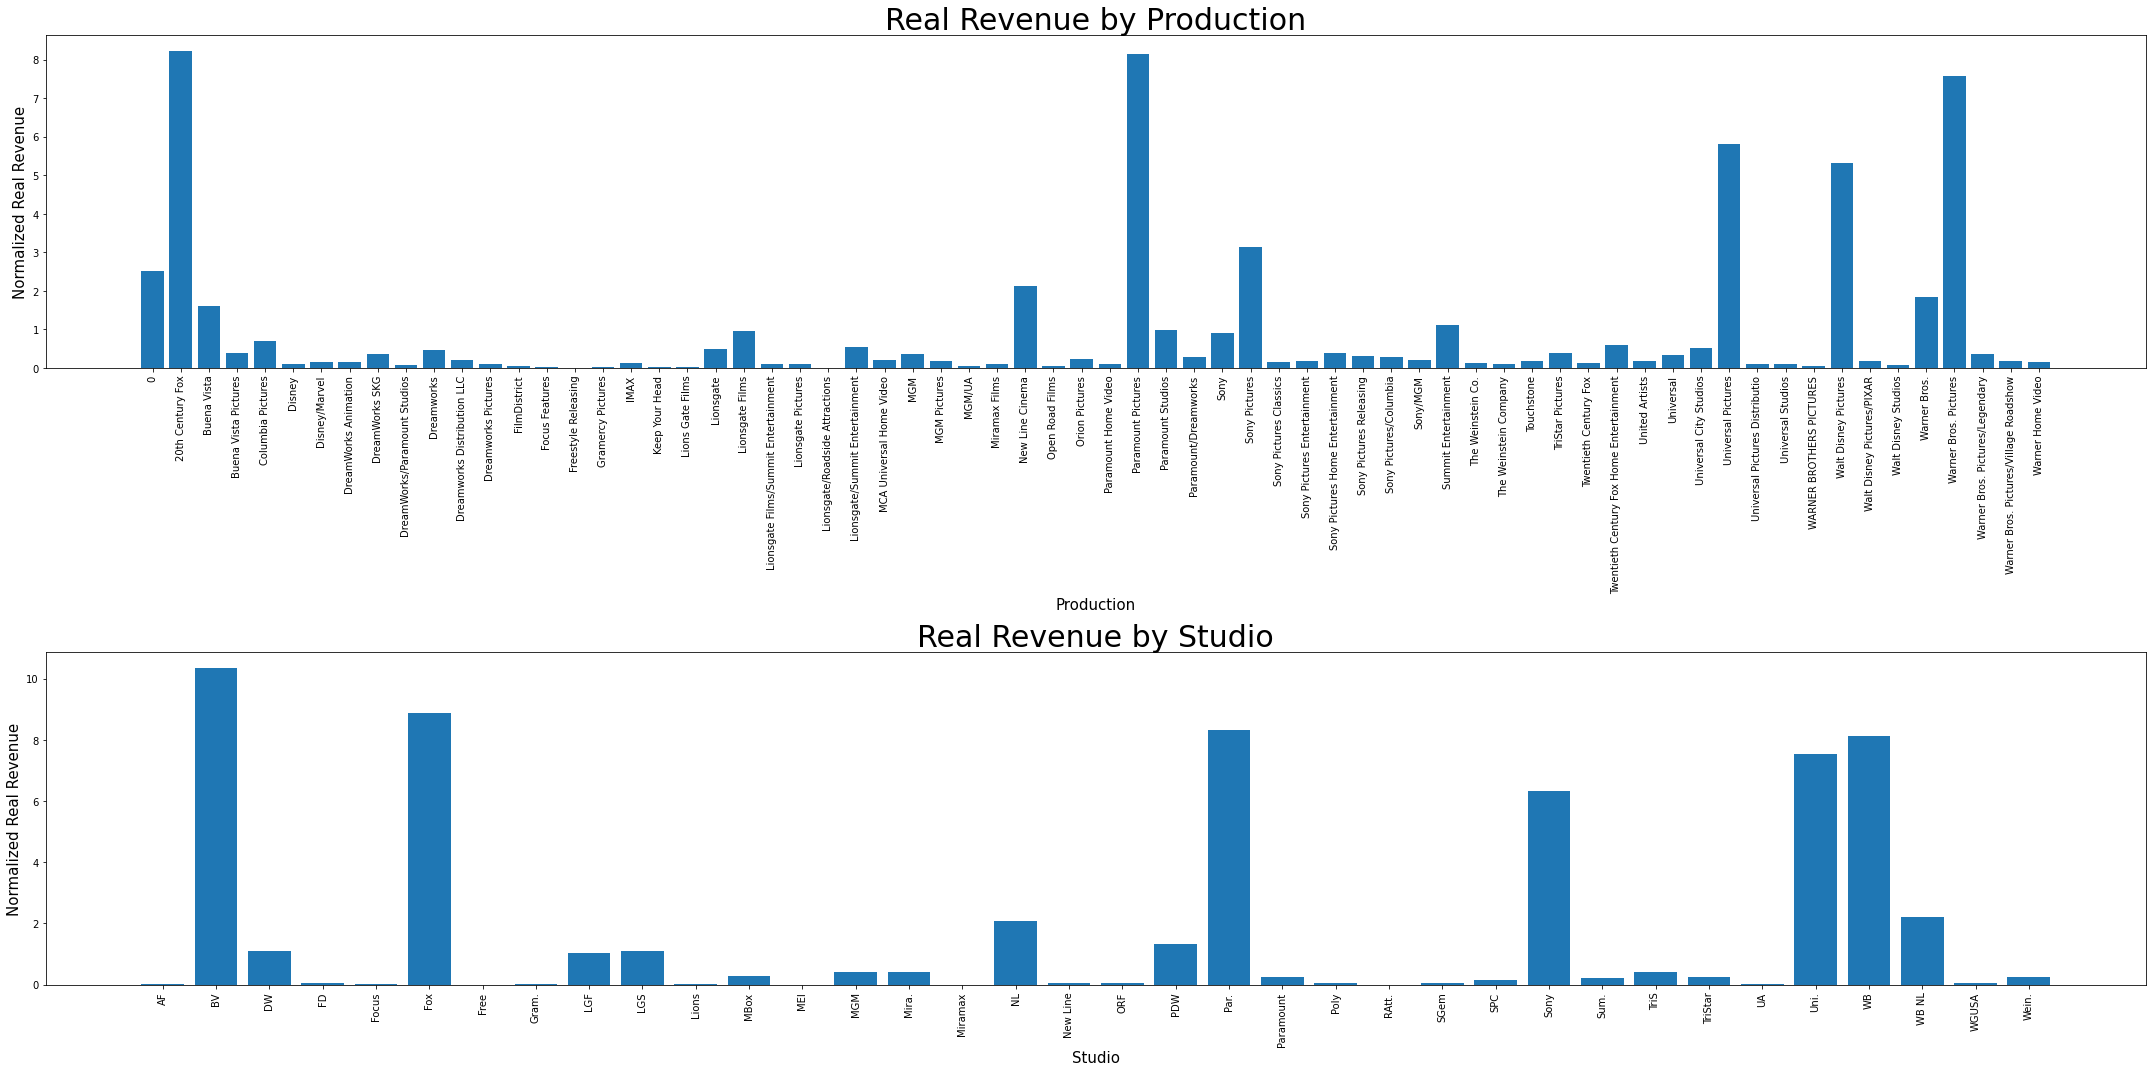

In [30]:
# Worldwide-gross to production studio
wwg_production_df = pd.DataFrame(OMdb.groupby(by=['Production']).sum()['real_revenue'])
wwg_studio_df = pd.DataFrame(OMdb.groupby(by=['studio']).sum()['real_revenue'])

plt.figure(figsize = (30,15))
ax1 = plt.subplot(2,1,1)
ax1.set_title('Real Revenue by Production', fontsize = 30)
ax1.bar(wwg_production_df.index, wwg_production_df['real_revenue'])
ax1.set_xlabel('Production', fontsize = 15)
ax1.set_xticklabels(wwg_production_df.index, rotation = 90)
ax1.set_ylabel('Normalized Real Revenue', fontsize = 15)

ax2 = plt.subplot(2,1,2)
ax2.set_title('Real Revenue by Studio', fontsize = 30)
ax2.bar(wwg_studio_df.index, wwg_studio_df['real_revenue'])
ax2.set_xlabel('Studio', fontsize = 15)
ax2.set_xticklabels(wwg_studio_df.index, rotation = 90)
ax2.set_ylabel('Normalized Real Revenue', fontsize = 15)

plt.tight_layout()
plt.savefig('real revenue to production vs. studio.png')

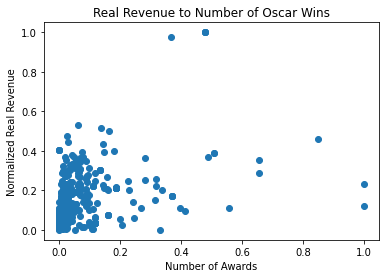

In [31]:
#Worldwide-gross to total # awards won
plt.scatter(OMdb['awards'], OMdb['real_revenue'])
plt.title('Real Revenue to Number of Oscar Wins')
plt.xlabel('Number of Awards')
plt.ylabel('Normalized Real Revenue')
plt.savefig('Real Revenue to Number of Oscar Wins.png');

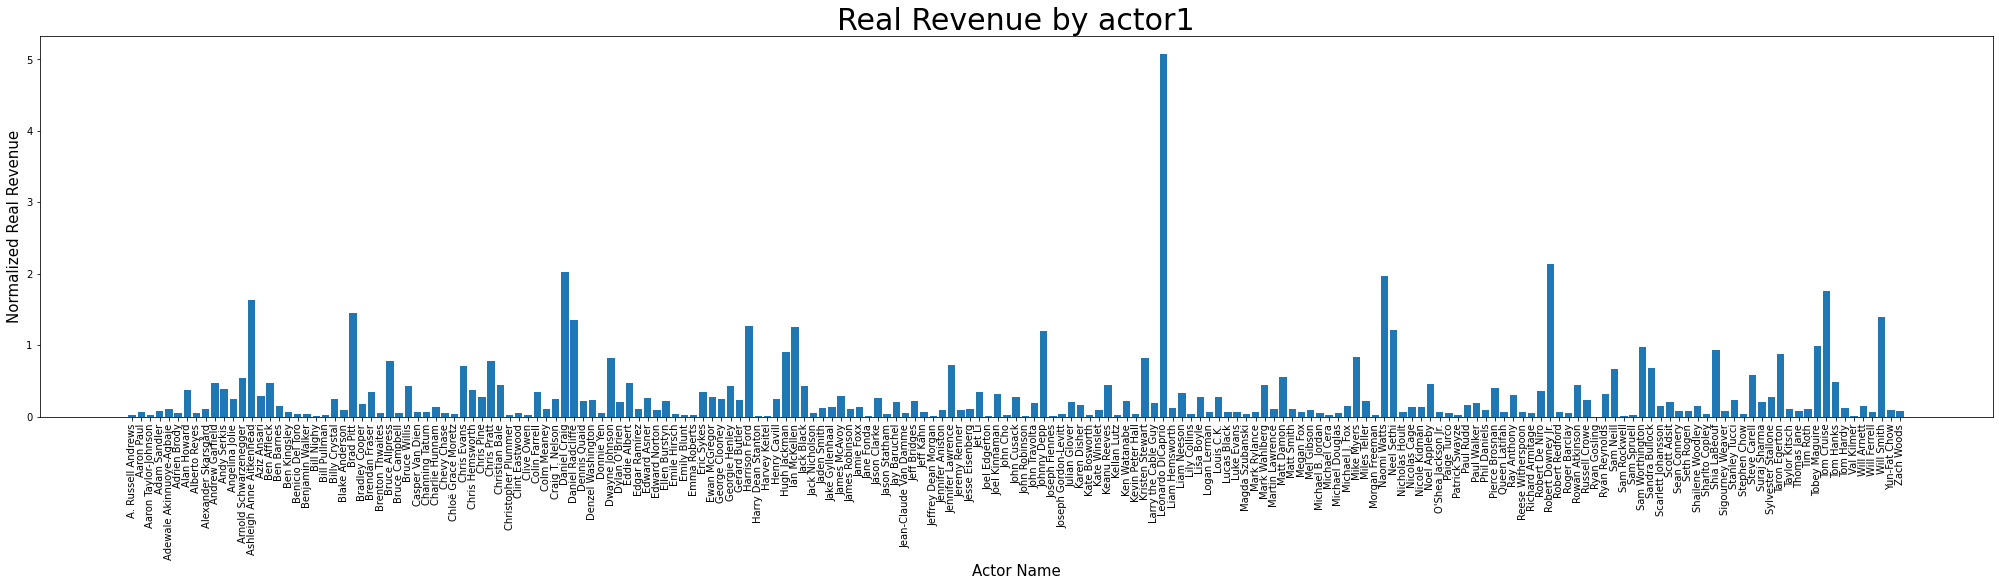

In [32]:
# Real Revenue to actor_1
wwg_actor1_df = pd.DataFrame(OMdb.groupby(by=['actor_1']).sum()['real_revenue'])
plt.figure(figsize = (35,7))
plt.bar(wwg_actor1_df.index, wwg_actor1_df['real_revenue'])
plt.title('Real Revenue by actor1', fontsize = 30)
plt.xlabel('Actor Name', fontsize = 15)
plt.ylabel('Normalized Real Revenue', fontsize = 15)
plt.xticks(rotation = 90)
plt.savefig('Real Revenue to actor1.png');

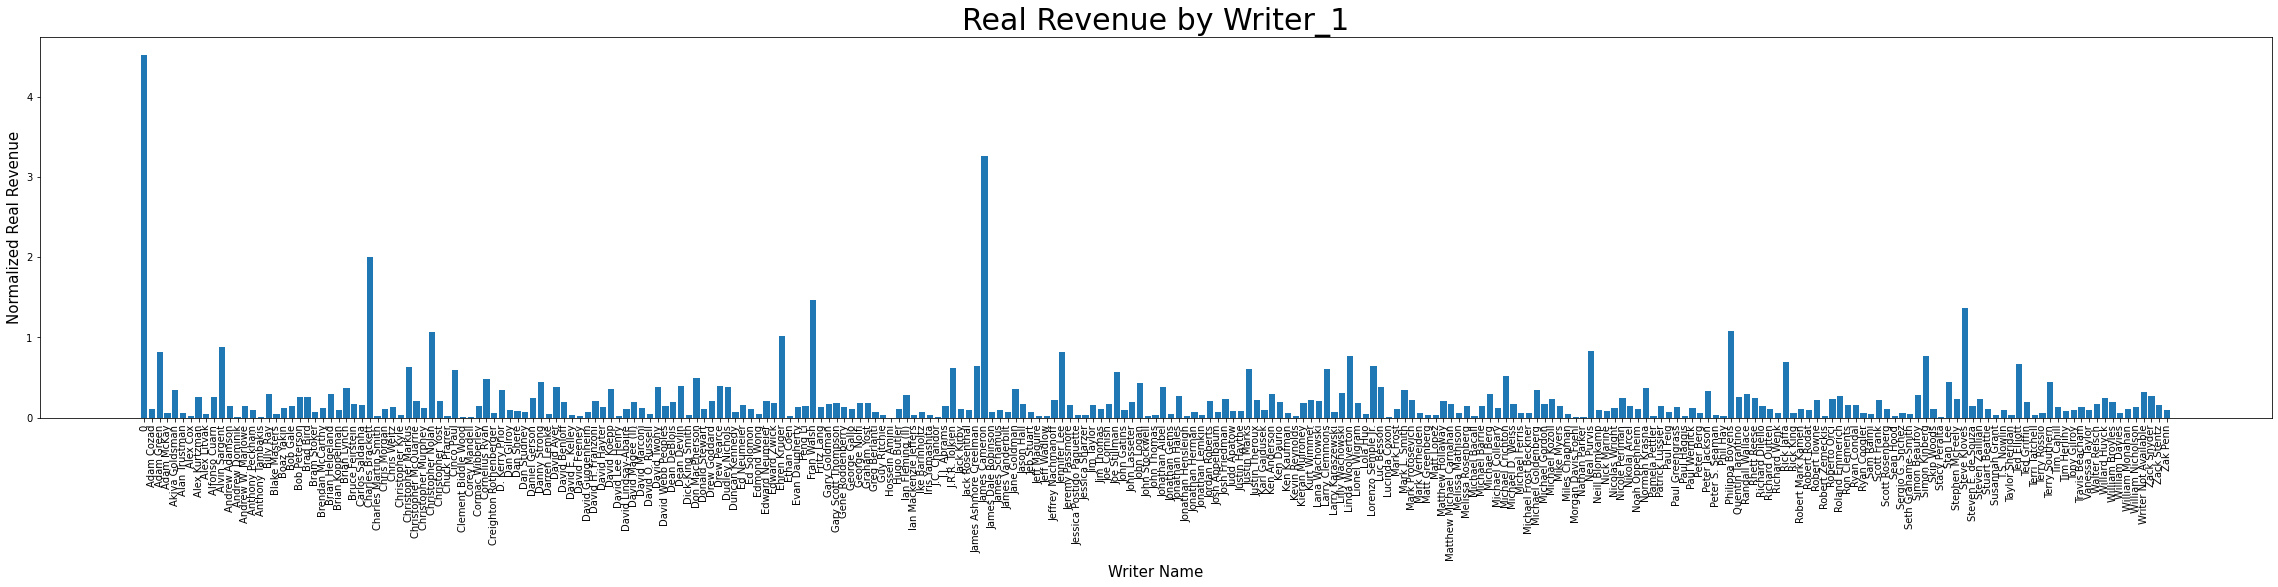

In [33]:
# Real Revenue to writer_1
wwg_writer_df = pd.DataFrame(OMdb.groupby(by=['Writer 1']).sum()['real_revenue'])
plt.figure(figsize = (40,7))
plt.bar(wwg_writer_df.index, wwg_writer_df['real_revenue'])
plt.title('Real Revenue by Writer_1', fontsize = 30)
plt.xlabel('Writer Name', fontsize = 15)
plt.ylabel('Normalized Real Revenue', fontsize = 15)
plt.xticks(rotation = 90)
plt.savefig('Real Revenue to writer_1.png');

Prediction Models

Criteria for BinaryClassification:
Target/label = 1 if worldwide-gross >= median of the worldwide-gross column (adjusted for inflation)
0 if otherwise

In [34]:
revenue_median = OMdb_ohed['real_revenue'].median()
OMdb_ohed['target_revenue']= OMdb_ohed['real_revenue'].map(lambda x: 1 if x >= revenue_median else 0)

In [35]:
revenue_median

0.1052042278598718

Feature Selection / Dimensionality Reduction:
Use SelectKBest to determine the highest impact features or combination of

In [36]:
# For the feature columns I dropped worldwide-gross because real_revenue comes from worldwide-gross
# I also droped domestic-gross and overseas-gross because worldwide-gross = domestic-gross + overseas-gross
X = OMdb_ohed.drop(columns = ['worldwide-gross','target_revenue','domestic-gross','overseas-gross','real_revenue'])
y = OMdb_ohed['target_revenue']

# Select the top 20 features using SelectKbest
skb = SelectKBest(chi2, k = 50)
skb = skb.fit(X, y)
df_scores = pd.DataFrame(skb.scores_)
df_columns = pd.DataFrame(X.columns)
feature_df = pd.concat([df_columns, df_scores],axis=1)
feature_df.columns = ['features', 'score']

In [37]:
feature_df['group_col'] = [each.split('_')[0] for each in feature_df['features']]

In [38]:
new_feature_df = feature_df.groupby(by= 'group_col').mean().sort_values(by = 'score', ascending =False)

In [39]:
top20_df = feature_df.nlargest(20, 'score')
top20_df = top20_df.sort_values(by = 'score', ascending = True )

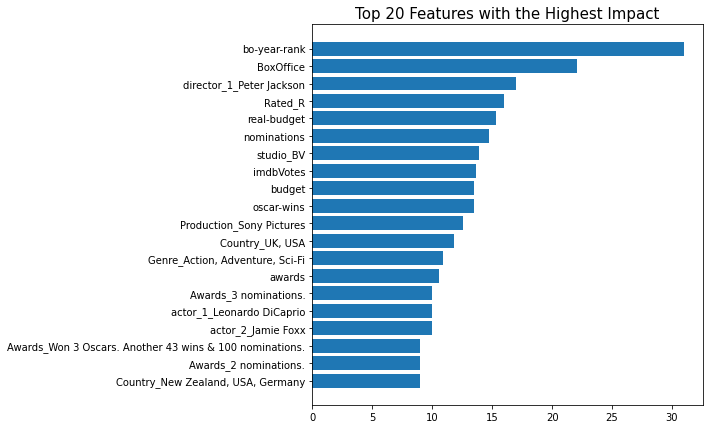

In [40]:
plt.figure(figsize=(7,7))
plt.barh(top20_df['features'], top20_df['score'])
plt.title('Top 20 Features with the Highest Impact', fontsize = 15)
plt.savefig('selected features and impact socre.png');

In [41]:
top_group = pd.DataFrame(top20_df.groupby(by = 'group_col').mean()['score']).sort_values(by = 'score', ascending= True)

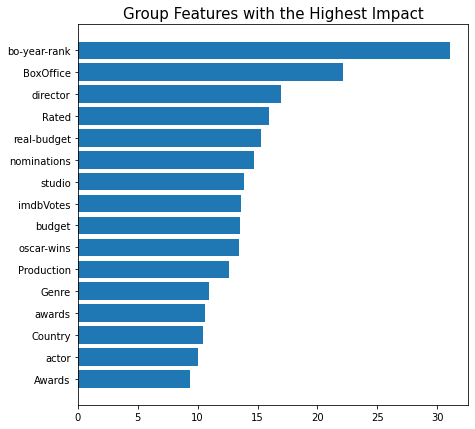

In [42]:
plt.figure(figsize=(7,7))
plt.barh(top_group.index, top_group['score'])
plt.title('Group Features with the Highest Impact', fontsize = 15)
plt.savefig('selected features and impact socre.png');

C) Training Set Setup: Use 20%/80%

In [43]:
selected_cols = [feature for feature in top20_df['features']]
X = OMdb_ohed[selected_cols]
y = OMdb_ohed['target_revenue']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 2020, stratify = y)

In [45]:
def metrics_output(ml, name):
    pred = ml.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    train_score = ml.score(X_train, y_train)
    test_score = ml.score(X_test, y_test)
    precision = tp/(tp+fp)
    recall = tp/(fn+tp)
    f = 2*precision * recall/(precision + recall)
    print(f'{name} training accuracy socre: {train_score}')
    print(f'{name} testing accuracy socre: {test_score}')
    print(f'{name}precision socre: {precision}')
    print(f'{name} recall socre: {recall}')
    print(f'{name} f-measure: {f}')
    

a) Logistic Regression

In [46]:
Logreg = LogisticRegression()
Logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Text(0.5, 1.0, 'Logistic Regression Confusion Matrics')

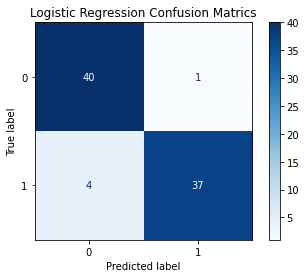

In [47]:
plot_confusion_matrix(Logreg, X_test, y_test, cmap = 'Blues')
plt.title('Logistic Regression Confusion Matrics')

In [48]:
metrics_output(Logreg, 'Logistic Regression')

Logistic Regression training accuracy socre: 0.9049079754601227
Logistic Regression testing accuracy socre: 0.9390243902439024
Logistic Regressionprecision socre: 0.9736842105263158
Logistic Regression recall socre: 0.9024390243902439
Logistic Regression f-measure: 0.9367088607594938


Text(0.5, 1.0, 'Logistic Regression ROC/AUC')

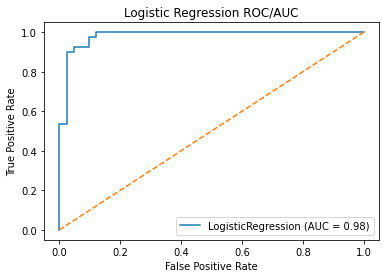

In [49]:
plot_roc_curve(Logreg, X_test, y_test)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         linestyle='--')
plt.title('Logistic Regression ROC/AUC')

b) SVM 

In [50]:
svm = SVC()

In [51]:
svm_params = {
    'C': np.linspace(0.0001, 1, 10),
    'kernel': ['rbf', 'linear']}

In [52]:
# use gridsearch to find out the best parameters
gs_svm = GridSearchCV(svm, svm_params, cv = 5)
gs_svm.fit(X_train, y_train)
gs_svm.best_params_

{'C': 1.0, 'kernel': 'linear'}

Text(0.5, 1.0, 'SVM confusion matrix')

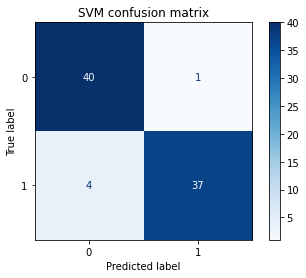

In [53]:
plot_confusion_matrix(gs_svm, X_test, y_test, cmap = 'Blues')
plt.title('SVM confusion matrix')

In [54]:
metrics_output(gs_svm, 'SVM with C = 1, kernel = rbf')

SVM with C = 1, kernel = rbf training accuracy socre: 0.9233128834355828
SVM with C = 1, kernel = rbf testing accuracy socre: 0.9390243902439024
SVM with C = 1, kernel = rbfprecision socre: 0.9736842105263158
SVM with C = 1, kernel = rbf recall socre: 0.9024390243902439
SVM with C = 1, kernel = rbf f-measure: 0.9367088607594938


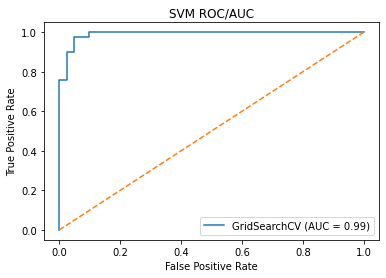

In [55]:
plot_roc_curve(gs_svm, X_test, y_test)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         linestyle='--')
plt.title('SVM ROC/AUC');

c) KNN

In [56]:
knn = KNeighborsClassifier()

In [57]:
knn_params = {
    'n_neighbors': [3, 5, 8],
    'metric': ['minkowski', 'manhattan']
}

In [58]:
gs_knn = GridSearchCV(knn, knn_params, cv =5)
gs_knn.fit(X_train, y_train)
gs_knn.best_params_

{'metric': 'minkowski', 'n_neighbors': 3}

Text(0.5, 1.0, 'KNN confusion matrix')

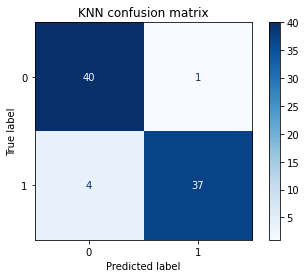

In [59]:
plot_confusion_matrix(gs_knn, X_test, y_test, cmap = 'Blues')
plt.title('KNN confusion matrix')

In [60]:
metrics_output(gs_knn, 'KNN with k = 3, distance metric = minkowski')

KNN with k = 3, distance metric = minkowski training accuracy socre: 0.950920245398773
KNN with k = 3, distance metric = minkowski testing accuracy socre: 0.9390243902439024
KNN with k = 3, distance metric = minkowskiprecision socre: 0.9736842105263158
KNN with k = 3, distance metric = minkowski recall socre: 0.9024390243902439
KNN with k = 3, distance metric = minkowski f-measure: 0.9367088607594938


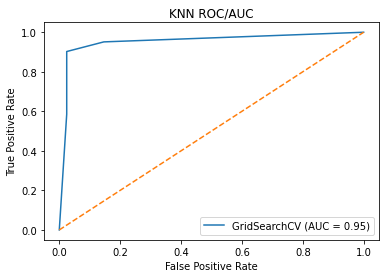

In [61]:
plot_roc_curve(gs_knn, X_test, y_test)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         linestyle='--')
plt.title('KNN ROC/AUC');

d) Naive Bayes

In [62]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Text(0.5, 1.0, 'Naive Bayes confusion matrix')

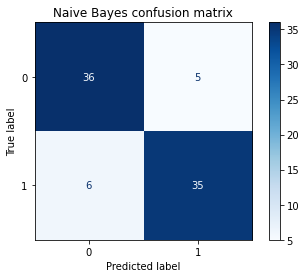

In [63]:
plot_confusion_matrix(nb, X_test, y_test, cmap = 'Blues')
plt.title('Naive Bayes confusion matrix')

In [64]:
metrics_output(nb, 'Naive Bayes')

Naive Bayes training accuracy socre: 0.8558282208588958
Naive Bayes testing accuracy socre: 0.8658536585365854
Naive Bayesprecision socre: 0.875
Naive Bayes recall socre: 0.8536585365853658
Naive Bayes f-measure: 0.8641975308641976


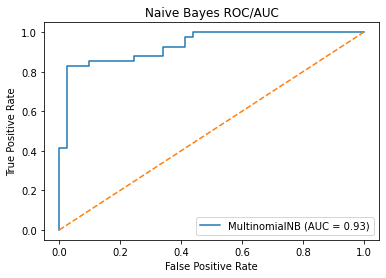

In [65]:
plot_roc_curve(nb, X_test, y_test)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         linestyle='--')
plt.title('Naive Bayes ROC/AUC');

In [66]:
# Since KNN and Logistic Regression have the exact same accuracy score, 
# we go with Logistic Regression to do the cross validation because Logreg has a higher AUC score
cross_val_score(Logreg, X, y, cv =5)

array([0.85365854, 0.97560976, 0.91463415, 0.87654321, 0.81481481])

In [67]:
cross_val_score(Logreg, X, y, cv =5).mean()

0.8870520927431496